## *Этап - Feature engineering и построение модели*

#### Импорт библиотек

Для работы с датафреймом использовал стандартые библиотеки. При построении модели пользовался библиотекой sklearn.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

In [43]:
df = pd.read_csv('database.csv', index_col=0)

##### Исходный датафрейм
На первый взгляд, датасет имеет:
- 2503 строк и 9 колонок;
- NaN значения в колонках *balcony_or_loggia, Bathroom, Year_built*;
- возможно имеются дубликаты;
- возможно колонки имеют неподходящий тип данных.

In [44]:
df

,Price,Rooms,Area,Floor,Max_house_floor,balcony\loggia,Bathroom,Year built,Link
0,4250000,1,40,13,25,балкон,совмещенный,2019.0,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
1,4000000,3,61.7,3,5,балкон,раздельный,1977.0,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
2,2950000,2,44,9,9,балкон,NaN,NaN,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
3,6990000,3,67.7,5,16,лоджия,раздельный,NaN,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
4,6990000,2,44.9,16,25,балкон,NaN,NaN,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
...,...,...,...,...,...,...,...,...,...
2498,3799999,3,57.1,9,10,лоджия,раздельный,1982.0,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
2499,3450000,1,37,2,6,балкон,совмещенный,2018.0,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
2500,3199000,1,38.3,3,7,NaN,NaN,NaN,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
2501,4930000,3,59,3,5,NaN,NaN,NaN,https://www.avito.ru/perm/kvartiry/3-k._kvarti...


Так как при парсинге я не исключал квартиры, которые могли дублироваться на соседних страницах, то их необходимо исключить.

In [45]:
print(df.shape)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)

(2503, 9)
(2331, 9)


In [46]:
df = df.rename(columns={'balcony\loggia': 'balcony_or_loggia', 'Year built': 'Year_built'})

#### Приведение признаков к соответствующему типу данных
Колонки Price, Area выдают ошибку при использовании метода *astype()*. При детальном рассмотреннии были выявлены неверно спарсированные данные в колонках:
1. Price
   - были включены квартиры без фиксированной цены в объявлении
1. Area
   - включились доли в квартире, жилые помещения со свободной планировкой и апартаменты

После удаления дубликатов и строк с явными ошибками размер датасета составляет 2302х9

In [47]:
df.dtypes

Price                 object
Rooms                  int64
Area                  object
Floor                  int64
Max_house_floor        int64
balcony_or_loggia     object
Bathroom              object
Year_built           float64
Link                  object
dtype: object

In [48]:
df.astype({'Price': 'int64'})

ValueError: invalid literal for int() with base 10: 'от2890000'

In [49]:
indx = []
for i in range(len(df.Price)):
    try:
        int(df.Price[i])
    except:
        indx.append(i)
df.iloc[indx]        

,Price,Rooms,Area,Floor,Max_house_floor,balcony_or_loggia,Bathroom,Year_built,Link
251,от2890000,1,1-к.,1,5,NaN,раздельный,NaN,https://www.avito.ru/perm/kvartiry/auktsion_1-...
263,от2399000,1,2-к.,7,16,NaN,совмещенный,1959.0,https://www.avito.ru/perm/kvartiry/auktsion_2-...
1256,от3100000,1,2-к.,15,16,лоджия,совмещенный,NaN,https://www.avito.ru/perm/kvartiry/auktsion_2-...
1483,от2660000,2,43.3,5,5,балкон,раздельный,1969.0,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
1853,от5599000,1,2-к.,4,9,балкон,раздельный,2016.0,https://www.avito.ru/perm/kvartiry/auktsion_2-...
1991,от4790000,1,1-к.,7,25,лоджия,совмещенный,2016.0,https://www.avito.ru/perm/kvartiry/auktsion_1-...
2117,от3150000,1,1-к.,4,5,лоджия,раздельный,2008.0,https://www.avito.ru/perm/kvartiry/auktsion_1-...
2211,от3370000,1,1-к.,2,5,балкон,раздельный,1993.0,https://www.avito.ru/perm/kvartiry/auktsion_1-...
2317,от11700000,1,2-к.,8,9,лоджия,раздельный,2017.0,https://www.avito.ru/perm/kvartiry/auktsion_2-...


In [50]:
df = df.drop(indx, axis=0)
df = df.reset_index(drop=True)

In [51]:
df = df.astype({'Price': 'int64'})
df.dtypes

Price                  int64
Rooms                  int64
Area                  object
Floor                  int64
Max_house_floor        int64
balcony_or_loggia     object
Bathroom              object
Year_built           float64
Link                  object
dtype: object

In [52]:
df.astype({'Area': 'float64'})

ValueError: could not convert string to float: 'апартаменты'

In [53]:
indx = []
for i in range(len(df.Area)):
    try:
        float(df.Area[i])
    except:
        indx.append(i)
df.iloc[indx]        

,Price,Rooms,Area,Floor,Max_house_floor,balcony_or_loggia,Bathroom,Year_built,Link
18,11850000,1,апартаменты,10,10,лоджия,раздельный,2018.0,https://www.avito.ru/perm/kvartiry/3-k._aparta...
370,22000000,1,в,1,9,балкон,раздельный,2014.0,https://www.avito.ru/perm/kvartiry/dolya_v_svo...
372,4700000,1,планировка,20,25,лоджия,раздельный,2004.0,https://www.avito.ru/perm/kvartiry/svob._plani...
483,1499999,1,в,5,5,балкон,раздельный,2019.0,https://www.avito.ru/perm/kvartiry/dolya_v_2-k...
579,1499999,1,в,2,2,NaN,NaN,NaN,https://www.avito.ru/perm/kvartiry/dolya_v_2-k...
661,7000000,1,апартаменты,11,17,лоджия,совмещенный,1996.0,https://www.avito.ru/perm/kvartiry/1-k._aparta...
727,2650000,1,апартаменты,3,9,NaN,совмещенный,NaN,https://www.avito.ru/perm/kvartiry/1-k._aparta...
792,9900000,1,планировка,1,5,балкон,раздельный,2012.0,https://www.avito.ru/perm/kvartiry/svob._plani...
914,1000000,1,апартаменты,8,19,NaN,совмещенный,1979.0,https://www.avito.ru/perm/kvartiry/1-k._aparta...
992,9900000,1,планировка,3,9,лоджия,раздельный,2012.0,https://www.avito.ru/perm/kvartiry/svob._plani...


In [54]:
df = df.drop(indx, axis=0)
df = df.reset_index(drop=True)

In [55]:
df = df.astype({'Area': 'float64'})
df.dtypes

Price                  int64
Rooms                  int64
Area                 float64
Floor                  int64
Max_house_floor        int64
balcony_or_loggia     object
Bathroom              object
Year_built           float64
Link                  object
dtype: object

In [56]:
df

,Price,Rooms,Area,Floor,Max_house_floor,balcony_or_loggia,Bathroom,Year_built,Link
0,4250000,1,40.0,13,25,балкон,совмещенный,2019.0,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
1,4000000,3,61.7,3,5,балкон,раздельный,1977.0,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
2,2950000,2,44.0,9,9,балкон,NaN,NaN,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
3,6990000,3,67.7,5,16,лоджия,раздельный,NaN,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
4,6990000,2,44.9,16,25,балкон,NaN,NaN,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
...,...,...,...,...,...,...,...,...,...
2297,3799999,3,57.1,9,10,лоджия,раздельный,1982.0,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
2298,3450000,1,37.0,2,6,балкон,совмещенный,2018.0,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
2299,3199000,1,38.3,3,7,NaN,NaN,NaN,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
2300,4930000,3,59.0,3,5,NaN,NaN,NaN,https://www.avito.ru/perm/kvartiry/3-k._kvarti...


#### Описательная статистика

In [57]:
df.describe()

,Price,Rooms,Area,Floor,Max_house_floor,Year_built
count,2.302000e+03,2302.000000,2302.000000,2302.000000,2302.000000,1358.000000
mean,4.475328e+06,2.080799,53.178888,5.702867,9.998697,1989.497054
std,2.744540e+06,0.920332,24.874859,4.772019,6.195391,53.253232
min,6.000000e+05,1.000000,10.900000,1.000000,1.000000,198.000000
25%,2.950000e+06,1.000000,38.000000,2.000000,5.000000,1971.000000
50%,3.750000e+06,2.000000,47.000000,4.000000,9.000000,1988.500000
75%,5.197999e+06,3.000000,62.000000,8.000000,14.000000,2013.000000
max,3.800000e+07,7.000000,392.000000,29.000000,31.000000,2022.000000


<AxesSubplot:xlabel='Floor', ylabel='Density'>

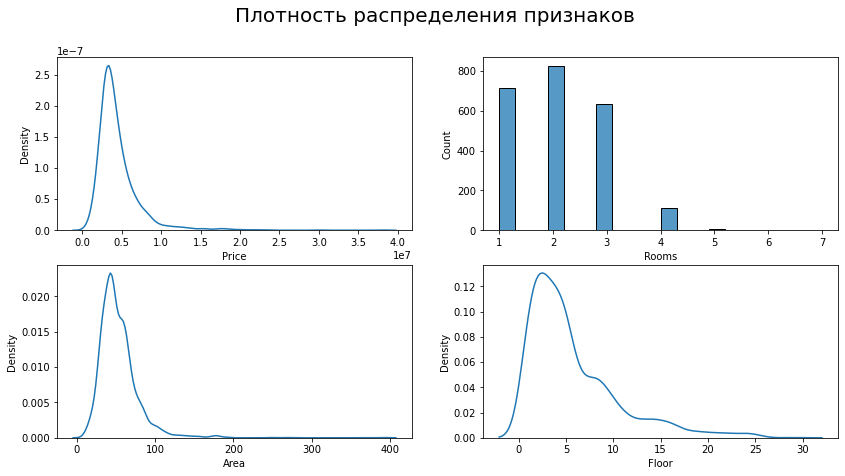

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(14,7))
fig.suptitle('Плотность распределения признаков', fontsize=20)

sns.kdeplot(data=df, x='Price', ax=axes[0, 0])
sns.histplot(data=df, x='Rooms', ax=axes[0, 1])
sns.kdeplot(data=df, x='Area', ax=axes[1, 0])
sns.kdeplot(data=df, x='Floor', ax=axes[1, 1])

<AxesSubplot:xlabel='Year_built'>

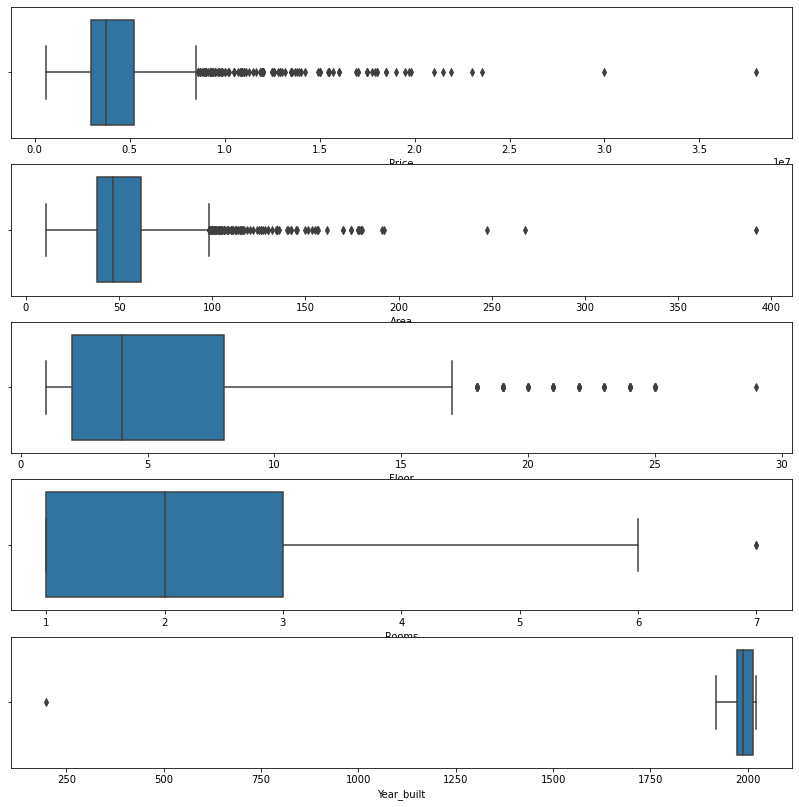

In [59]:
fig, axes = plt.subplots(5, 1, figsize=(14,14))

sns.boxplot(data=df, x='Price', ax=axes[0])
sns.boxplot(data=df, x='Area', ax=axes[1])
sns.boxplot(data=df, x='Floor', ax=axes[2])
sns.boxplot(data=df, x='Rooms', ax=axes[3])
sns.boxplot(data=df, x='Year_built', ax=axes[4])

In [19]:
df = df.drop(labels=df[df['Price'] > 10000000].index)
df = df.drop(labels=df[df['Year_built'] < 1930].index)
df = df.drop(labels=df[df['Area'] > 100].index)
df = df.drop(labels=df[df['Floor'] > 14].index)
df = df.reset_index(drop=True)

<AxesSubplot:xlabel='Area', ylabel='Price'>

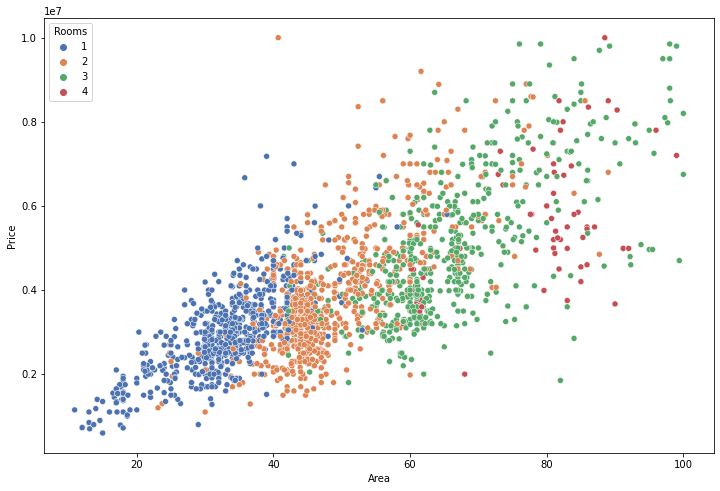

In [21]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Area', y='Price', hue='Rooms', palette='deep')

<AxesSubplot:xlabel='Year_built', ylabel='Price'>

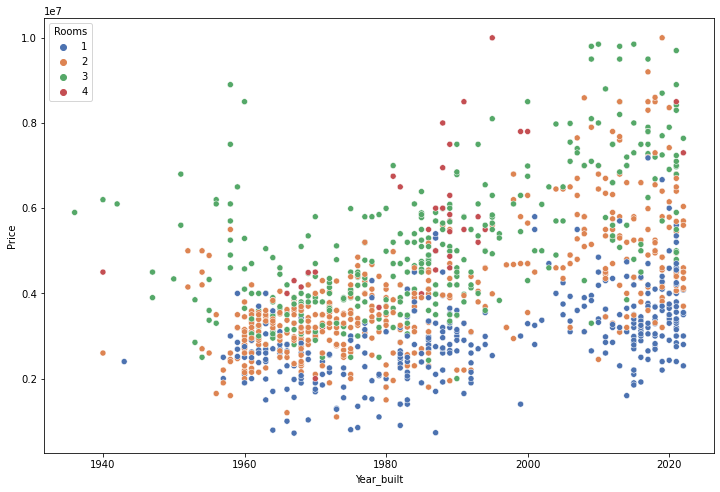

In [131]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_new, x='Year_built', y='Price', hue='Rooms', palette='deep')

## Построение модели для прогнозирования цены

### Случайный лес для 2302х4

In [143]:
X = df.drop(columns=['Price', 'balcony_or_loggia', 'Bathroom', 'Year_built', 'Link'])
y = df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [161]:
param_grid = {'max_depth': [5], 'random_state': [42]}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)
grid.score(X_train, y_train)

0.7716753670417664

In [162]:
grid.score(X_test, y_test)

0.6932923235492855

In [72]:
for column, importance in zip(X.columns, grid.best_estimator_.feature_importances_):
    print(f'{column}: {importance:.3f}')

Rooms: 0.010
Area: 0.826
Floor: 0.013
Max_house_floor: 0.151


### Случайный лес для 943х7

In [165]:
for column in df.columns[-4:-1]:
    print(df[column].isna().value_counts())
    print('-'* 30)

print('Кол-во строк со всеми признаками:',
      df[['Bathroom', 'balcony_or_loggia', 'Year_built']]
      .isna()
      .query('Bathroom == False & balcony_or_loggia == False & Year_built == False')
      .shape[0]
      )

False    1362
True      687
Name: balcony_or_loggia, dtype: int64
------------------------------
False    1698
True      351
Name: Bathroom, dtype: int64
------------------------------
False    1201
True      848
Name: Year_built, dtype: int64
------------------------------
Кол-во строк со всеми признаками: 943


Используя все признаки, модель показала плохой обобщающий результат, так же features_importance_ выявил значимый признак лишь Year_built.

### Случайный лес для 1201х6

In [263]:
df_new = df.drop(columns=['balcony_or_loggia', 'Bathroom'])
df_new = df_new.dropna()
df_new = df_new.reset_index(drop=True)
df_new = df_new.astype({'Year_built': 'int64'})
df_new

,Price,Rooms,Area,Floor,Max_house_floor,Year_built,Link
0,4250000,1,40.0,13,25,2019,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
1,4000000,3,61.7,3,5,1977,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
2,3700000,1,50.0,2,19,2020,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
3,2990000,1,34.1,4,9,1986,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
4,3150000,2,49.3,3,12,1982,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
...,...,...,...,...,...,...,...
1196,3350000,2,42.7,5,5,1964,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
1197,1600000,2,44.9,2,2,1958,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
1198,3799999,3,57.1,9,10,1982,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
1199,3450000,1,37.0,2,6,2018,https://www.avito.ru/perm/kvartiry/1-k._kvarti...


In [264]:
X = df_new.drop(columns=['Price', 'Link'])
y = df_new.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

param_grid = {'max_depth': [4], 'random_state': [42]}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)

print('Обучающий:', grid.score(X_train, y_train))
print('Тестовый:', grid.score(X_test, y_test), end ='\n\n')

for column, importance in zip(X.columns, grid.best_estimator_.feature_importances_):
    print(f'{column}: {importance:.3f}')

Обучающий: 0.7489911572505522
Тестовый: 0.7361061547600324

Rooms: 0.001
Area: 0.769
Floor: 0.011
Max_house_floor: 0.068
Year_built: 0.151


In [265]:
df_new.to_csv('df.csv', index=True)

### Построение модели для отправки link  на похожие объекты

In [226]:
scores_data = pd.DataFrame()
pipe_neighbor = make_pipeline(StandardScaler(), KNeighborsRegressor())
for i in range(1, 40):
    parameters_neighbor = {'kneighborsregressor__n_neighbors': [i]}
    grid_neighbor = GridSearchCV(pipe_neighbor, parameters_neighbor, cv=5)
    grid_neighbor.fit(X_train, y_train)
    train_score = grid_neighbor.score(X_train, y_train)
    test_score = grid_neighbor.score(X_test, y_test)
    temp_score_data = pd.DataFrame({'n_neighbors': [i], 'train_score': [train_score], 'test_score': [test_score]})
    scores_data = pd.concat([scores_data, temp_score_data], ignore_index=True)

<AxesSubplot:xlabel='n_neighbors'>

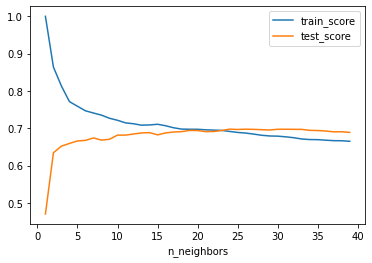

In [227]:
scores_data.plot(x='n_neighbors', y=['train_score', 'test_score'])

In [229]:
pipe_neighbor = make_pipeline(StandardScaler(), KNeighborsRegressor())
parameters_neighbor = {'kneighborsregressor__n_neighbors': [10]}
grid_neighbor = GridSearchCV(pipe_neighbor, parameters_neighbor, cv=5)
grid_neighbor.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [10]})

In [243]:
grid_neighbor.score(X_train, y_train)

0.7215210425072934

In [244]:
grid_neighbor.score(X_test, y_test)

0.6819109597894162

In [256]:
a = grid_neighbor.best_estimator_[1].kneighbors(X_train.iloc[[10]], return_distance=False)[0]

In [259]:
for i in a:
    print(df.iloc[i, -1])

https://www.avito.ru/perm/kvartiry/2-k._kvartira_382m_15et._2318632151
https://www.avito.ru/perm/kvartiry/2-k._kvartira_43m_55et._2319381562
https://www.avito.ru/perm/kvartiry/2-k._kvartira_635m_44et._2324311182
https://www.avito.ru/perm/kvartiry/3-k._kvartira_57m_99et._2377395156
https://www.avito.ru/perm/kvartiry/1-k._kvartira_30m_25et._2346137925
https://www.avito.ru/perm/kvartiry/2-k._kvartira_56m_511et._2329605322
https://www.avito.ru/perm/kvartiry/2-k._kvartira_43m_25et._2388929190
https://www.avito.ru/perm/kvartiry/2-k._kvartira_41m_25et._2396074413
https://www.avito.ru/perm/kvartiry/3-k._kvartira_86m_1414et._2329389998
https://www.avito.ru/perm/kvartiry/2-k._kvartira_40m_1015et._2373227245


### Сохранение модели

In [245]:
import pickle

In [247]:
with open('model_price.pkl','wb') as f:
    pickle.dump(grid,f)
with open('model_links.pkl','wb') as f:
    pickle.dump(grid_neighbor,f)